## Ranjan et al. 2016 Implementation 
https://github.com/EmuKit/emukit/blob/main/notebooks/Emukit-tutorial-Bayesian-optimization-introduction.ipynb

In [1]:
#magic command to import TrentoWrapper classes and methods to this notebook.
%run -i TrentoWrapper.ipynb

### Model parametrs of interest:
    1. Normalization (N)
    2. Trento_p (p)

### Observables
    1. Multiplicity [0-5]
    2. e2 [0-5]



In [2]:
trento = TrentoWrapper(projectile="Pb", target="Pb", sqrts=2760., nevents=1000,
                     norm=10., nucleon_width=1., num_constits=1, constit_width=None, trento_p=0., fluctuation=1.,
                     grid_max=15., grid_step=0.1, random_seed=32,
                     centrality_bins=[(0.00,0.05)],
                     event_transform=lambda nev, b, npart, mult, e2, e3, e4, e5: (e2,),
                     bin_transform=lambda events: np.mean(events, axis=0))

    

In [3]:
from joblib import Parallel, delayed, cpu_count


In [4]:
def simulation(N,p):
    """Run trento simulation for a design point
    
    Parameters
    ---------
    N (float): Normalization
    p (float): Trento_p
    
    Returns
    -------
    numpy array with dimesnions (2,)
        [multiplicity [0-5], e2 [0-5]]
    """
    result = trento.run(norm=N, trento_p=p)
    return result.ravel()

In [5]:
%%time
ll = simulation(20,0)

CPU times: user 16 ms, sys: 8.87 ms, total: 24.8 ms
Wall time: 12 s


In [6]:
def simulation_parallel(design_matrix, n_process=cpu_count()):
    """Run trento simulation in parallel
    
    Parameters
    ----------
    
    design_matrix (ndarray): (n_design, n_model_parameters)
    n_process (int): number of processors to use
    
    Returns
    -------
    numpy array with dimensions (n_design, n_observables)"""
    
    observations = Parallel(n_jobs=n_process)(delayed(simulation)(*params) for ii, params in enumerate(design_matrix))
    return np.array(observations)

In [7]:
import numpy as np
true_param = np.array([20,0]).reshape(1,2)

In [8]:
import emcee
from scipy.optimize import minimize
import corner
import ptemcee
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from emukit.core import ParameterSpace, ContinuousParameter
from GPy.models import MultioutputGP
from GPy import likelihoods
from emukit.model_wrappers import GPyMultiOutputWrapper
from GPy.kern import RBF, White
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from GPy.models import GPRegression
import GPy

import random
random.seed(1)

from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pyDOE import *
from scipy.stats import norm
from scipy import integrate
import corner

import math
%matplotlib inline 

from emcee.ptsampler import PTSampler
from sklearn.preprocessing import StandardScaler

# set seaborn style
import seaborn as sns
sns.set_style("white")

In [9]:
lb = [10,-1]
ub = [30,1]
parameter_space = ParameterSpace([ContinuousParameter('N', lb[0], ub[0]),ContinuousParameter('p', lb[1], ub[1])])

In [11]:
n_exp = 10 # 10 experimenal data points
noise_exp = [10, 0.001] # standard error
mu_exp = list(np.array(simulation_parallel(true_param)).flatten()) # true function output
sigma2_exp = [[noise_exp[0]**2,0],[0,noise_exp[1]**2]] # assume independent noise

# experimental data for Bayesian Inference
y_exp = np.random.multivariate_normal(mu_exp, sigma2_exp, n_exp) # sampled outputs with noise
dy_exp = np.ones(true_param.shape[1]) * noise_exp

# parameters for Active Learning
mu_list = list(np.mean(y_exp, axis=0))
sigma_list = list(np.sqrt(np.var(y_exp, axis=0)))
print(mu_list, sigma_list)

[3657.3231737205365, 0.08803331596409139] [13.478727880188009, 0.0010816440939291994]


In [12]:
dy_exp

array([1.e+01, 1.e-03])

Save Experimental Data (for ApproxPosterior):

In [13]:
filename = 'Experimental_Data/Trento_2d_ExpData.txt'
np.savetxt(filename, y_exp)
filename = 'Experimental_Data/Trento_2d_dyExpData.txt'
np.savetxt(filename, dy_exp)

### Target Posterior Distribution

log likelihood derivation:(for simulator)  
  
One observable:  
$L(\theta;y_1,\cdots,y_n) \propto \frac{1}{\sqrt{2\pi \sigma_{exp}^2}}exp\{\sum_{i=1}^n(y_i-\eta(\theta))^2\}$  
$logL(\theta;y_1,\cdots,y_n) \propto -0.5log(2\pi \sigma_{exp}^2) - 0.5\frac{1}{\sigma_{exp}^2}\sum_{i=1}^n(y_i-\eta(\theta))^2$  
where $\sigma_{exp}^2$ is experimental noise variance  
  
d observables:  
$logL(\theta;y_{11},\cdots,y_{n1},\cdots,y_{1d},\cdots,y_{nd}) = \sum_{i=1}^d logL(\theta;y_{1i},\cdots,y_{ni})$

In [14]:
theta_min = [1, -1]
theta_max = [30, 1]

# independent uniform prior
def log_flat_prior(theta):
    # The parameters are stored as a vector of values, so unpack them
    theta1, theta2 = theta
    # We're using only uniform priors in [0,1]
    if (theta_min[0] <= theta1) and (theta1 <= theta_max[0]) and (theta_min[1] <= theta2) and (theta2 <= theta_max[1]):
        return 0. # log(1)
    else:
        return -np.inf  # log(0)
    
# log_flat_prior = np.vectorize(log_flat_prior)

def sim_output(xx, obsno):
    """This generates output from simulator."""
    X = xx.reshape(-1, ndim)
    y = simulation(X[0,0],X[0,1])
    return y[obsno]

# define log likelihood
def log_likelihood_sim(theta, y_exp, dy_exp):
    '''
    Log-likelihood for data y_exp.
    theta: 2d vector;
    y_exp: n_exp by 2;
    dy_exp: 2d vector (experimental noise is the same for different observations).
    '''
    log_lik = 0
    for obs in range(y_exp.shape[1]): # number of observables
        y_pred = sim_output(theta, obs) # simulator (the same value for one input theta)
        sigma2 = dy_exp[obs]**2. + 0 # no simulator uncertainty
        log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) - 0.5/sigma2 * np.sum((y_pred - y_exp[:,obs])**2)    
    return log_lik

#posterior using flat prior
def log_posterior_flat_prior_sim(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood_sim(theta, y_exp, dy_exp)

In [15]:
%%time
# ptemcee
# https://emcee.readthedocs.io/en/develop/user/pt/
from emcee.ptsampler import PTSampler
ndim = 2
Tmax = 10
ntemps = 2
nwalkers = 4
# starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
starting_guesses = np.random.uniform(low=lb,high=ub,size=(ntemps,nwalkers,ndim))
#starting_guesses[:,:,0]= starting_guesses[:,:,0]
sampler = PTSampler(nwalkers, ndim, log_likelihood_sim, log_flat_prior, Tmax=Tmax, 
                    ntemps=ntemps, loglargs=[y_exp, dy_exp], threads=8)

# burn in
for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=10):
    pass
sampler.reset()

# record every 10
for p, lnprob, lnlike in sampler.sample(p, iterations=50, thin=1):
    pass

# resulting chains
assert sampler.chain.shape == (ntemps, nwalkers, 50, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)

CPU times: user 3.76 s, sys: 1.41 s, total: 5.17 s
Wall time: 1h 9min 58s


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

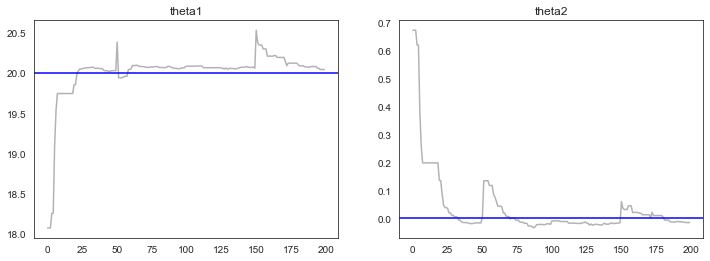

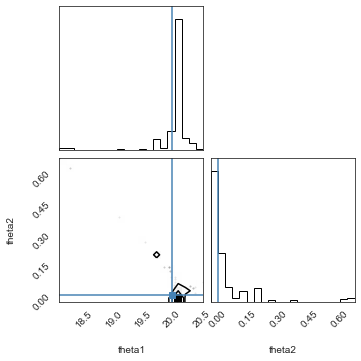

In [16]:
# plots & save data for R analysis
sim_T0chain = sampler.chain[0,...].reshape(-1,ndim)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(sim_T0chain[:,0], '-', color='k', alpha=0.3)
ax1.axhline(y=true_param[0][0], color='blue')
ax1.title.set_text('theta1')

ax2.plot(sim_T0chain[:,1], '-', color='k', alpha=0.3)
ax2.axhline(y=true_param[0][1], color='blue')
ax2.title.set_text('theta2')
plt.show()

tmp = corner.corner(sim_T0chain, labels=['theta1','theta2'], 
                truths=[true_param[0][0],true_param[0][1]])

In [17]:
MCMC_sim = pd.DataFrame(sim_T0chain)
MCMC_sim.to_csv('Outputs/Trento_2d_MCMCSim.csv', index=False)

### Active Learning

In [15]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

### --- Figure config
LEGEND_SIZE = 15

from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace

from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement
from emukit.core.optimization import GradientAcquisitionOptimizer

In [47]:
n_init = 20
n_total = 35
ndim = 2

log likelihood derivation:(for emulator)  
  
One observable:  
$L(\theta;y_1,\cdots,y_n) \propto \frac{1}{\sqrt{2\pi \sigma^{*2}(\theta)}}exp\{\sum_{i=1}^n(y_i-\hat{\eta}(\theta))^2\}$  
$logL(\theta;y_1,\cdots,y_n) \propto -0.5log(2\pi \sigma^{*2}(\theta)) - 0.5\frac{1}{\sigma^{*2}(\theta)}\sum_{i=1}^n(y_i-\hat{\eta}(\theta))^2$  
where $\sigma^{*2}(\theta) = s^2(\theta) + \sigma_{exp}^2$  
  
d observables:  
$logL(\theta;y_{11},\cdots,y_{n1},\cdots,y_{1d},\cdots,y_{nd}) = \sum_{i=1}^d logL(\theta;y_{1i},\cdots,y_{ni})$

In [48]:
sigma_list

[13.478727880188009, 0.0010816440939291994]

In [52]:
def fw(X):
    Y = simulation_parallel(X)
    Y1 = Y[:,0]
    W1 = Y1**2 - 2*Y1*mu_list[0] + mu_list[0]**2 + sigma_list[0]**2.
    Y2 = Y[:,1]
    W2 = Y2**2 - 2*Y2*mu_list[1] + mu_list[1]**2 + sigma_list[1]**2.
    output = (W1/np.mean(Y1)**2)+(W2/np.mean(Y2)**2) # how to scale them?
    return output.reshape(-1,1)

Iteration 0
Iteration 1: x_new = [22.97 -1.  ]; EI = [21.95]
Iteration 2: x_new = [20.32  1.  ]; EI = [1.06]
Iteration 3: x_new = [18.71  1.  ]; EI = [12.91]
Iteration 4: x_new = [21.14 -0.69]; EI = [6.43]
Iteration 5: x_new = [19.45  0.23]; EI = [3.4]
Iteration 6: x_new = [21.01 -0.49]; EI = [1.09]
Iteration 7: x_new = [19.72  0.12]; EI = [0.88]
Iteration 8: x_new = [21.35 -1.  ]; EI = [0.94]
Iteration 9: x_new = [19.56  0.25]; EI = [0.28]
Iteration 10: x_new = [21.24 -0.98]; EI = [0.18]
Iteration 11: x_new = [21.16 -0.62]; EI = [0.]
Iteration 12: x_new = [19.61  0.16]; EI = [0.05]
Iteration 13: x_new = [20.29 -0.31]; EI = [1.17]
Iteration 14: x_new = [19.06  0.52]; EI = [0.42]


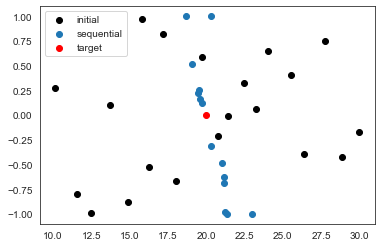

In [53]:
i = 0
# initial sample size
X = lhs(n=ndim, samples=n_init, criterion='maximin', iterations=10)
max_iterations = n_total - n_init
X[:,0] = X[:,0]*20 + 10
X[:,1] = X[:,1]*2 - 1
W = fw(X)

kernel1 = RBF(input_dim=2, ARD=True)
gpy_model = GPy.models.GPRegression(X, W, kernel1, noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)
print('Iteration ' + str(i))

#---# BO Procedure
for i in range(1,n_total-n_init):
    # define EI function
    ei_acquisition = ExpectedImprovement(emukit_model)

    # optimize EI function
    optimizer = GradientAcquisitionOptimizer(parameter_space)
    x_new, opt_acq = optimizer.optimize(ei_acquisition)

    print('Iteration ' + str(i) + ': x_new = ' + str(np.round(x_new.flatten(),2)) + '; EI = ' + str(np.round(opt_acq.flatten(),2)))

    # update emulator with additional point
    w_new = fw(x_new)
    X = np.append(X, x_new, axis=0)
    W = np.append(W, w_new, axis=0)
    emukit_model.set_data(X, W)

    #mu_plot, var_plot = emukit_model.predict(X_plot)

n_end = len(X)
fig, ax = plt.subplots()
ax.scatter(X[0:n_init,0],X[0:n_init,1], color='black', label='initial')
ax.scatter(X[n_init:n_end,0],X[n_init:n_end,1], label='sequential')
ax.scatter(true_param[:,0], true_param[:,1], color='red', label='target')
n = np.arange(0,X[0:n_end,:].shape[0])
# for i, txt in enumerate(n):
#     ax.annotate(txt, (X[i,0], X[i,1]))
plt.legend()

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square


Optimization restart 1/20, f = 577.3264191744092
Warning - optimization restart 2/20 failed
Optimization restart 3/20, f = 3042.6972428873137
Optimization restart 4/20, f = 149.84452297307922
Optimization restart 5/20, f = 410.160073920335
Warning - optimization restart 6/20 failed
Optimization restart 7/20, f = 474.2917981954142
Optimization restart 8/20, f = 464.3691547830076
Optimization restart 9/20, f = 153.41278460688602
Optimization restart 10/20, f = 1160.5505531856306
Warning - optimization restart 11/20 failed
Optimization restart 12/20, f = 152.6044585001732
Optimization restart 13/20, f = 1082.1422569845502
Optimization restart 14/20, f = 427.29265155449247
Warning - optimization restart 15/20 failed
Warning - optimization restart 16/20 failed
Optimization restart 17/20, f = 158.3983735005306
Warning - optimization restart 18/20 failed
Warning - optimization restart 19/20 failed
Optimization restart 20/20, f = 4783.648864401989
Done with burnin


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

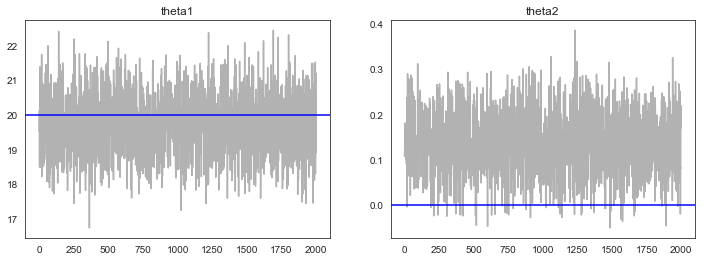

CPU times: user 16.6 s, sys: 1.28 s, total: 17.9 s
Wall time: 2min 56s


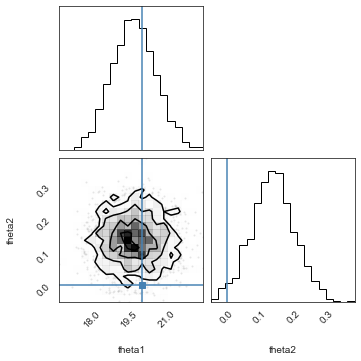

In [54]:
%%time
#---# Bayesian inference
x_ranjan = X.copy()
y_ranjan = simulation_parallel(x_ranjan)

# train GP

kernel1 = RBF(input_dim=2, ARD=True)
kernel2 = RBF(input_dim=2, ARD=True)
model_gpy = MultioutputGP([x_ranjan,x_ranjan],[y_ranjan[:,0].reshape(-1,1),y_ranjan[:,1].reshape(-1,1)],
                          likelihood_list=[likelihoods.Gaussian(),likelihoods.Gaussian()],
                          kernel_list=[kernel1,kernel2])
model = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=20)
model.optimize()

def emu_predict(xx, obsno):
    """This function handles the scaling and GP interpolation together, 
    returning our prediction in the ordinary observable space
    rather than the scaled observable space.
    This map is what we call our 'emulator'. """
    X = xx.reshape(-1, ndim)
    new_column = [[obsno]]*len(X)
    pred_temp = model.predict(np.append(X,new_column,axis=1))
    y = pred_temp[0] # vector of predictive means
    s2_vec = pred_temp[1]
    dy = np.sqrt(s2_vec)
    return y, dy

def log_likelihood(theta, y_exp, dy_exp):
    '''
    Log-likelihood for data y_exp.
    theta: 2d vector;
    y_exp: n_exp by 2;
    dy_exp: 2d vector (experimental noise is the same for different observations).
    '''
    #use our GP emulator for prediction
    log_lik = 0
    for obs in range(y_exp.shape[1]): # number of observables
        y_pred, s_pred = emu_predict(theta, obs) # emulator prediction and uncertainty
        sigma2 = dy_exp[obs]**2. + s_pred**2. # emulator uncertainty
        log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) - 0.5/sigma2 * np.sum((y_pred - y_exp[:,obs])**2)    
    return log_lik

#posterior using flat prior
def log_posterior_flat_prior(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood(theta, y_exp, dy_exp)

# ptemcee
ntemps = 2
nwalkers = 20
starting_guesses = np.random.uniform(low=lb,high=ub,size=(ntemps,nwalkers,ndim))
sampler = PTSampler(nwalkers, ndim, log_likelihood, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp],
                   threads=8)

# burn in
for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=1000):
    pass
sampler.reset()
print('Done with burnin')
# record every 10
for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
    pass

# resulting chains
assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)

# plots & save data for R analysis
prop_T0chain = sampler.chain[0,...].reshape(-1,ndim)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(prop_T0chain[:,0], '-', color='k', alpha=0.3)
ax1.axhline(y=true_param[0][0], color='blue')
ax1.title.set_text('theta1')

ax2.plot(prop_T0chain[:,1], '-', color='k', alpha=0.3)
ax2.axhline(y=true_param[0][1], color='blue')
ax2.title.set_text('theta2')
plt.show()

tmp = corner.corner(prop_T0chain, labels=['theta1','theta2'], 
                truths=[true_param[0][0],true_param[0][1]])

MCMC_sim = pd.DataFrame(prop_T0chain)
MCMC_sim.to_csv('Outputs/Trento_2d_MCMCRanjan2016_init'+str(n_init)+'_seq'+str(n_total-n_init)+'.csv', index=False)

### Random LHD:

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:144: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:145: RuntimeWarning:overflow encountered in square
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:146: RuntimeWarning:invalid value encountered in add


Warning - optimization restart 1/10 failed
Warning - optimization restart 2/10 failed
Optimization restart 3/10, f = 1626.4733710987853


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/10, f = 786.8558703902027
Warning - optimization restart 5/10 failed
Optimization restart 6/10, f = 1111.5508240396439
Optimization restart 7/10, f = 382.27625433005625
Optimization restart 8/10, f = 507.36146625348584
Warning - optimization restart 9/10 failed
Optimization restart 10/10, f = 155.60859499384316


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:43: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:45: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ptemcee/util.py:80: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

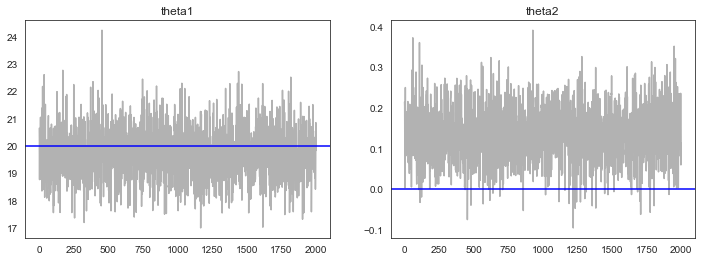

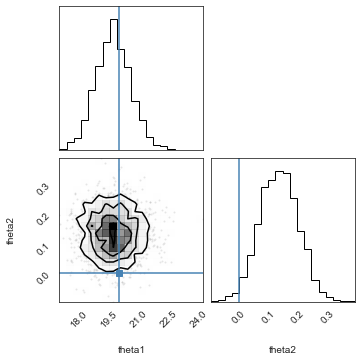

In [56]:
x_ref = lhs(n=2, samples=n_total) # no criterion specified: random design
x_ref[:,0] = x_ref[:,0]*20 + 10
x_ref[:,1] = x_ref[:,1]*2 - 1
y_ref = simulation_parallel(x_ref)

# train GP
kernel1 = RBF(input_dim=2, ARD=True)
kernel2 = RBF(input_dim=2, ARD=True)
model_gpy = MultioutputGP([x_ref,x_ref],[y_ref[:,0].reshape(-1,1),y_ref[:,1].reshape(-1,1)],
                          likelihood_list=[likelihoods.Gaussian(),likelihoods.Gaussian()],
                          kernel_list=[kernel1,kernel2])
model_ref = GPyMultiOutputWrapper(model_gpy, n_outputs=2, n_optimization_restarts=20)
model_ref.optimize()

def emu_ref_predict(xx, obsno):
    """This function handles the scaling and GP interpolation together, 
    returning our prediction in the ordinary observable space
    rather than the scaled observable space.
    This map is what we call our 'emulator'. """
    X = xx.reshape(-1, ndim)
    new_column = [[obsno]]*len(X)
    pred_temp = model_ref.predict(np.append(X,new_column,axis=1))
    y = pred_temp[0] # vector of predictive means
    s2_vec = pred_temp[1]
    dy = np.sqrt(s2_vec)
    return y, dy

# define log likelihood
def log_likelihood_ref(theta, y_exp, dy_exp):
    '''
    Log-likelihood for data y_exp.
    theta: 2d vector;
    y_exp: n_exp by 2;
    dy_exp: 2d vector (experimental noise is the same for different observations).
    '''
    #use our GP emulator for prediction
    log_lik = 0
    for obs in range(y_exp.shape[1]): # number of observables
        y_pred, s_pred = emu_predict(theta, obs) # emulator prediction and uncertainty
        sigma2 = dy_exp[obs]**2. + s_pred**2. # emulator uncertainty
        log_lik = log_lik - 0.5*np.log(2.*np.pi*sigma2) - 0.5/sigma2 * np.sum((y_pred - y_exp[:,obs])**2)    
    return log_lik

#posterior using flat prior
def log_posterior_flat_prior_ref(theta, y_exp, dy_exp):
    '''Log posterior for data y_exp and uncertainties 
        dy_exp given parameter array theta, assuming prior is flat.'''
    return log_flat_prior(theta) + log_likelihood_ref(theta, y_exp, dy_exp)


# ptemcee
# https://emcee.readthedocs.io/en/develop/user/pt/
ntemps = 2
nwalkers = 20
# starting_guesses = np.ones(ntemps*nwalkers*ndim).reshape(ntemps,nwalkers,ndim)*0.5 + np.random.rand(ntemps,nwalkers,ndim) * 0.1
starting_guesses = np.random.uniform(low=lb,high=ub,size=(ntemps,nwalkers,ndim))
sampler = PTSampler(nwalkers, ndim, log_likelihood_ref, log_flat_prior, ntemps=ntemps, loglargs=[y_exp, dy_exp],
                   threads=8)

# burn in
for p, lnprob, lnlike in sampler.sample(starting_guesses, iterations=1000):
    pass
sampler.reset()

# record every 10
for p, lnprob, lnlike in sampler.sample(p, iterations=1000, thin=10):
    pass

# resulting chains
assert sampler.chain.shape == (ntemps, nwalkers, 100, ndim)

# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)

# Longest autocorrelation length (over any temperature)
max_acl = np.max(sampler.acor)


# plots & save data for R analysis
LHD_T0chain = sampler.chain[0,...].reshape(-1,ndim)
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(LHD_T0chain[:,0], '-', color='k', alpha=0.3)
ax1.axhline(y=true_param[0][0], color='blue')
ax1.title.set_text('theta1')

ax2.plot(LHD_T0chain[:,1], '-', color='k', alpha=0.3)
ax2.axhline(y=true_param[0][1], color='blue')
ax2.title.set_text('theta2')
plt.show()

tmp = corner.corner(LHD_T0chain, labels=['theta1','theta2'], 
                truths=[true_param[0][0],true_param[0][1]])

MCMC_LHD = pd.DataFrame(LHD_T0chain)
MCMC_LHD.to_csv('Outputs/Trento_2d_MCMCLHD_total'+str(n_total)+'.csv', index=False)